In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
import os
experiment_result = {}
for file in os.listdir("experiments"):
    if file.endswith(".pickle"):
        with open(f"experiments/{file}","rb") as f:
            data = pickle.load(f)
        f.close()
        experiment_result[file.split(".")[0]] = data

In [10]:
experiment_result["binomial_ftm_rflvm"]["X"].shape

(1000, 2332, 2)

In [3]:
import numpy as np
from scipy.linalg import svd 
from typing import Tuple

def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):

    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = svd(np.dot(Phi.T,np.asarray(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return np.dot(Phi, R)


def rotate_factors(player_factor_tensor:np.ndarray, use_varimax:bool = True)->Tuple[np.ndarray, np.ndarray]:
    """

    Args:
        player_factor_tensor (np.ndarray): sample x num factors x num players 
        varimax (bool): whether to apply varimax rotation or not

    Returns:
        np.ndarray: sample x num factors x num players  rotated tensor
    """

    n_samples, n_factors, _ = player_factor_tensor.shape
    output_tensor = np.zeros_like(player_factor_tensor)
    rotations = [np.eye(n_factors)]
    output_tensor[0,:,:] = player_factor_tensor[0,:,:] if not use_varimax else varimax(player_factor_tensor[0,:,:])
    for i in range(1,n_samples):
        U, _, V =  svd(output_tensor[0,:,:].dot(player_factor_tensor[i,:,:].T), full_matrices=False)
        rotation = U.dot(V)
        rotations.append(rotation)
        output_tensor[i,:,:] = rotation.dot(player_factor_tensor[i,:,:])
    print(len(rotations))
    return output_tensor, np.stack(rotations,axis = 0)




In [6]:
rotated_experiment_results = {}
# for model in experiment_result:
#     print(model, experiment_result[model]["X"])
#     rotated_experiment_results[model] = rotate_factors(np.swapaxes(experiment_result[model]["X"], axis1 = 1, axis2=2))

rotated_experiment_results["poisson_ast_rflvm"] = rotate_factors(np.swapaxes(experiment_result["poisson_ast_rflvm"]["X"],1,2))
rotated_experiment_results["poisson_stl_rflvm"] = rotate_factors(np.swapaxes(experiment_result["poisson_stl_rflvm"]["X"],1,2))
rotated_experiment_results["poisson_dreb_rflvm"] = rotate_factors(np.swapaxes(experiment_result["poisson_dreb_rflvm"]["X"],1,2))
rotated_experiment_results["poisson_oreb_rflvm"] = rotate_factors(np.swapaxes(experiment_result["poisson_oreb_rflvm"]["X"],1,2))
rotated_experiment_results["gaussian_bpm_rflvm"] = rotate_factors(np.swapaxes(experiment_result["gaussian_bpm_rflvm"]["X"],1,2))
rotated_experiment_results["gaussian_dbpm_rflvm"] = rotate_factors(np.swapaxes(experiment_result["gaussian_dbpm_rflvm"]["X"],1,2))
rotated_experiment_results["gaussian_obpm_rflvm"] = rotate_factors(np.swapaxes(experiment_result["gaussian_obpm_rflvm"]["X"],1,2))
rotated_experiment_results["binomial_ftm_rflvm"] = rotate_factors(np.swapaxes(experiment_result["binomial_ftm_rflvm"]["X"],1,2))
rotated_experiment_results["binomial_fg2m_rflvm"] = rotate_factors(np.swapaxes(experiment_result["binomial_fg2m_rflvm"]["X"],1,2))
rotated_experiment_results["binomial_fg3m_rflvm"] = rotate_factors(np.swapaxes(experiment_result["binomial_fg3m_rflvm"]["X"],1,2))

1000
1000
1000
1000
1000
1000
1000
1000
1000


AxisError: axis2: axis 2 is out of bounds for array of dimension 2

In [12]:
rotated_means_results = {model : rotated_experiment_results[model][0].mean(axis=0).T for model in  rotated_experiment_results}

{'poisson_ast_rflvm': array([[-0.77955127, -0.31252417],
        [ 3.03080943, -0.66348468],
        [-0.21793832,  0.41636184],
        ...,
        [-0.51433442,  0.46664878],
        [ 0.12029459, -0.12547487],
        [-0.97031239,  0.58311113]]),
 'poisson_stl_rflvm': array([[-0.75296253,  0.2707299 ],
        [-1.17499283,  0.33398007],
        [-0.48201936,  0.11116952],
        ...,
        [-0.22202047, -0.11665657],
        [-0.04909354, -0.03588178],
        [-0.50164334, -0.02004732]]),
 'poisson_dreb_rflvm': array([[-0.32803275, -0.04177471],
        [ 0.6788238 , -0.15288084],
        [ 0.58459001,  1.07821281],
        ...,
        [ 0.07606217,  0.2658391 ],
        [ 0.65828453,  0.61112861],
        [ 0.03153441,  0.20541559]]),
 'poisson_oreb_rflvm': array([[-0.32679272, -0.65372727],
        [-1.22579498, -1.36049519],
        [-2.12453759, -0.85430798],
        ...,
        [-0.18662108, -0.11846142],
        [-1.20553109, -1.06959759],
        [-0.96883192, -0.520

In [14]:
import pandas as pd
df = pd.read_csv("datasets/player_data.csv")

In [ ]:
df = df.sort_values(by=["id","year"])


In [16]:
def plot_scatter(dataframe, rotated_means_dict, metric, model, offset = "minutes"):
    key_name = f"{model}_{metric}_rflvm"
    df_size_vals = np.log(dataframe[[offset,"id"]].groupby("id").mean().reset_index())
    if model == "binomial":
        df_color_vals = dataframe[[key_name,offset, "id"]].groupby("id").sum().reset_index()
        plt.scatter(rotated_means_dict[key_name][:,0], rotated_means_dict[key_name][:,1], c = df_color_vals[metric]/df_color_vals[offset],s=df_size_vals[offset] )
    elif model == "poisson":
        df_color_vals = dataframe[[metric,offset,"id"]].groupby("id").max().reset_index()
        plt.scatter(rotated_means_dict[key_name][:,0], rotated_means_dict[key_name][:,1], c = df_color_vals[metric]/df_color_vals[offset],s=df_size_vals[offset] )
    elif model == "gaussian":
        df_color_vals = dataframe[[metric, "id"]].groupby("id").mean().reset_index()
        plt.scatter(rotated_means_dict[key_name][:,0], rotated_means_dict[key_name][:,1], c = df_color_vals[metric],s=df_size_vals[offset] )
    plt.title(metric)
    
    

    


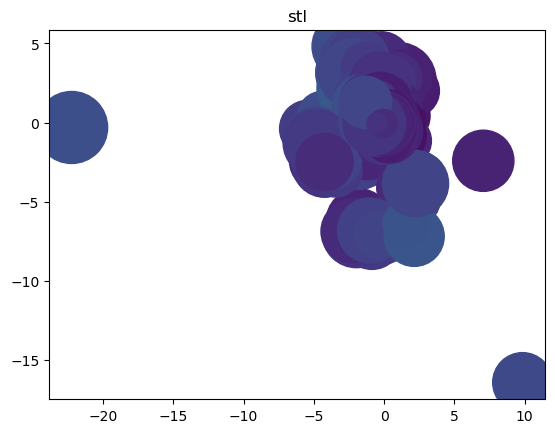

In [17]:
plot_scatter(df, rotated_means_results, "stl", "poisson")

In [ ]:
plt.scatter(rotated_means[:,0], rotated_means[:,1], c= df_max_vals["fg3m"]/df_max_vals["fg3a"])
